In [1]:
import numpy as np, random
import math
import matplotlib.pyplot as plt
from timeit import default_timer as timer
%matplotlib inline

plt.style.use('seaborn-whitegrid')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [2]:
def exact_m(x): #for theoretical behaviour of magnetization
    if x<+2.269: return (1-1/(np.sinh(2/x))**4)**(1/8)
    else: return 0

In [3]:
X1 = np.linspace(1, 4, 100)
real_m = [exact_m(i) for i in X1]

In [4]:
color_list = ['tomato', 'orange', 'teal', 'k']

In [102]:
def metro(spins, T_list, L, time_measure, therm, nsteps):
    """ 
        Performs the Metropolis algorithm for a given T_list
        spins: Initial configuration of spins
        T_list: Temperatures for evaluation
        N: Number of spins
        time_measure: True if want to measure time for iteration
        therm: thermalization steps
        nsteps: total number of iterations for measurement
    """    
    M = sum(spins)
    neighbors = Neighbors(L)
    N = L**2
    M_list, X_list, m = [], [], []
    times = []
    for T in T_list:
        ctr = 0
        if time_measure == True:
            start = timer()
        # print('T=', T)
        beta = 1./T
        M_tot = 0.
        n_measures = 0
        for step in range(nsteps):
            for _ in range(N): #sweep over whole lattice
                k = random.randint(0, N - 1)
                delta_E = 2.0 * spins[k] * sum(spins[j] for j in neighbors[k])
                if random.uniform(0.0, 1.0) <= math.exp(-beta * delta_E):
                    spins[k] *= -1
                    M += 2*spins[k]
                    ctr +=1
            M_tot += abs(M)
            if step >= therm:
                m.append(abs(M)/N)
                n_measures += 1
        M_list.append(M_tot/(n_measures*N))
        X_list.append(np.var(m[:]))
        m.clear()
        # print('Acceptance rate:', (ctr/(nsteps*N))*100)
        if time_measure == True:
            end = timer()
            times.append(end-start)
    return M_list, X_list, times

In [18]:
def wolff(spins, T_list, L, time_measure, therm, spin_flips):
    """ 
        Performs the Metropolis algorithm for a given T_list
        spins: Initial configuration of spins
        T_list: Temperatures for evaluation
        N: Number of spins
        time_measure: True if want to measure time for iteration
        therm: thermalization steps
        spin_flips: total number of iterations for measurement
    """    
    M = sum(spins)
    neighbors = Neighbors(L)
    N = L**2
    times = [] #to measure time per iteration
    M_list, X_list, m = [], [], [] #susceptibility list

    for T in T_list:
        if time_measure == True:
            start = timer()
        # print("T = ",T)
        p  = 1.0 - math.exp(-2.0 / T)
        M_tot = 0.0
        flipped_spins = 0
        nsteps = 0
        while flipped_spins <  spin_flips:
            i = random.randint(0, N - 1)
            cluster, frontier = [i], [i]
            while frontier != []:
                j = random.choice(frontier)
                for k in neighbors[j]:
                    if spins[k] == spins[j] and k not in cluster and random.uniform(0.0, 1.0) <= p:
                        frontier.append(k)
                        cluster.append(k)
                frontier.remove(j)
            for l in cluster:
                spins[l] *= -1
            M -= 2*len(cluster)*spins[i]
            flipped_spins += len(cluster)
            if flipped_spins>therm:
                M_tot += abs(M)
                m.append(abs(M)/N)
                nsteps +=1 
        # acfn.append(m[:])
        M_list.append(M_tot/float(nsteps)/N)
        X_list.append(np.var(m[:]))
        m.clear()
        if time_measure == True:
            end = timer()
            times.append(end-start)

    return M_list, X_list, times

#16m44s without printing time N*1000, 30 temp steps - time measurement
#10m51s without printing time N*1000, 30 temp steps - no time measurement

In [7]:
## Identifies the nearest neighbours of spin numbered i.
## Note that edges are identified, so that there are no boundaries.
def right(i, L):
    if (i+1)%L == 0: return i+1-L 
    else: return i+1

def left(i, L):
    if i%L == 0: return i-1+L
    else: return i-1

def up(i, L):
    N = L**2
    return (i+L)%N

def down(i, L):
    N = L**2
    return (i-L+N)%N

def Neighbors(L): 
    N = L**2
    return [[right(i, L),left(i, L),up(i, L),down(i, L)] for i in range(N)]

In [8]:
# L = 20
# N = L**2

#something went wrong for L=32, T[1, 1.05,....., 4], spin_flips = N*1000, only print time

In [9]:
orientations = [-1, 1]

T_start = 1.
T_end = 4.
delta_T = 21
T_list = np.linspace(T_start, T_end, delta_T)

In [48]:
M_list_wol, X_list_wol = [], []
M_list_metro, X_list_metro = [], []
L_list = [10, 15, 20, 24]
for L in L_list:
    N = L**2
    spin_flips = N*1000
    spins = [random.choice(orientations) for i in range(N)]
    a, b, c = wolff(spins, T_list, L, False, 0, spin_flips)
    A, B, C = metro(spins, T_list, L, False, spin_flips/2, spin_flips)
    M_list_wol.append(a)
    X_list_wol.append(b)
    M_list_metro.append(A)
    X_list_metro.append(B)
    print(L)

10
15
20
24


**Mean Magnetization**

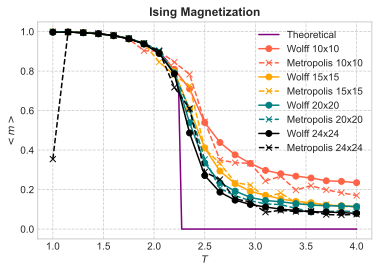

In [49]:
plt.xlabel('$T$', fontweight='bold')
plt.ylabel('$<m>$', fontweight='bold')
plt.title('Ising Magnetization', fontweight='bold')
plt.plot(X1, real_m, color='purple', label='Theoretical')
plt.grid(linestyle = '--')
# plt.scatter(T_list, M_list, color='tomato', edgecolors='black', s=50, label='Wolff')
# plt.scatter(T_list, M_list1, color='tomato', edgecolors='black', s=50, marker='x', label='Metropolis')
for i in range(len(L_list)):
    plt.plot(T_list, M_list_wol[i], color=color_list[i], label=f'Wolff {L_list[i]}x{L_list[i]}', marker='o')
    plt.plot(T_list, M_list_metro[i], color=color_list[i], label=f'Metropolis {L_list[i]}x{L_list[i]}', marker='x', linestyle = '--')

plt.legend()

**Susceptibility**

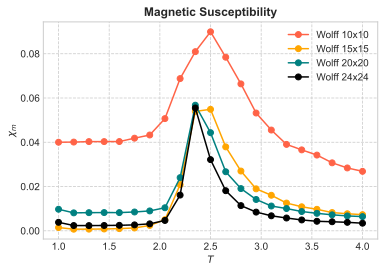

In [51]:
plt.cla()
plt.xlabel('$T$', fontweight='bold')
plt.ylabel('$\chi_{m}$', fontweight='bold')
plt.title('Magnetic Susceptibility', fontweight='bold')
for i in range(len(L_list)):
    plt.plot(T_list, X_list_wol[i], color=color_list[i], label=f'Wolff {L_list[i]}x{L_list[i]}', marker='o')
    # plt.plot(T_list, X_list_metro[i], color=color_list[i], label=f'Metropolis {L_list[i]}x{L_list[i]}', marker='x', linestyle = '--')
plt.legend()
plt.grid(linestyle = '--')

**Time Measurement for Critical Slowing down**

Here, we take $T$ values around a neighbourhood of $T_C$

In [112]:
T_list = [2. + 0.09*i for i in range(8)]
T_list

[2.0, 2.09, 2.18, 2.27, 2.36, 2.45, 2.54, 2.63]

In [113]:
L = 20
N = L**2
spins = np.ones(N)
ntot = 10000
thermal = 3000

In [114]:
A, B, C = metro(spins, T_list, L, True, thermal, ntot)
a, b, c = wolff(spins, T_list, L, True, thermal, ntot)

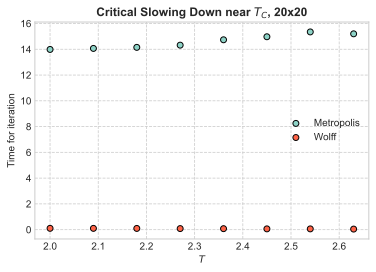

In [116]:
plt.title('Critical Slowing Down near $T_C$, 20x20', fontweight='bold')
plt.scatter(T_list, C, label='Metropolis', edgecolors='k')
plt.scatter(T_list, c, label = 'Wolff', color='tomato', edgecolors='k')
plt.xlabel('$T$')
plt.ylabel('Time for iteration')
plt.grid(linestyle='--')
plt.legend()

**Estimation of Critical exponent $\beta$**

In [142]:
dim = 30
n = dim*dim
new_spin = [random.choice([-1, 1]) for i in range(n)]
Temp = np.linspace(1.5, 2.5, 30)

In [143]:
Mag_list, x, t = wolff(new_spin, Temp, dim, False, 0, n*1000)

In [145]:
data = [0.98216413896956,0.9842108646737384,0.9821256971256972,0.9794912728820774,0.9758597380650613,0.9725714888677852,0.9696372948677746,0.9663809230136705,0.960999594484996,0.9551522484371849,0.9496506808762581,0.9422796593384828,0.9364350215940322,0.9271534936998854,0.9172746681518611,0.9021383647798742,0.8919081551860649,0.8743551433968744,0.8546874227823078,0.8341986234021632,0.7867221510883482,0.7463566482434407,0.6626968514181629,0.6079823375687123,0.5147354020687354,0.4230851688693098,0.34865626710454295,0.295844769746874,0.2530420602789024,0.2265392840539284]
# copied the output of Mag_list so as to not waste time running it again

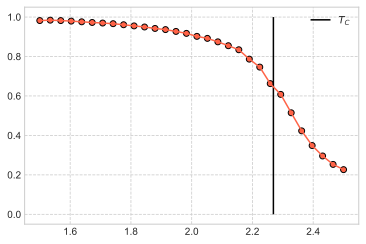

In [146]:
plt.scatter(Temp, data, color='tomato', edgecolors='k')
plt.plot(Temp, data, color='tomato')
plt.vlines(2.269, 0, 1, color='k', label='$T_C$')
plt.legend()
plt.grid(linestyle='--')